In [2]:
import torch # CUDA 12.6 version used
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np

In [3]:
# Base Hyperparameters

batch_size = 128
epoch_num = 25
patience = 3
learning_rate = 0.001

In [4]:
# Set Device to GPU if Available

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Arrange Training, Validation, and Testing Data

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

all_training_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testing_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_size = int(0.9 * len(all_training_data))
validation_size = len(all_training_data) - training_size
training_data, validation_data = random_split(all_training_data, [training_size, validation_size])

training_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True, num_workers=2)
testing_loader = torch.utils.data.DataLoader(testing_data, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
# Base Model

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pool = nn.MaxPool2d(stride=2, kernel_size=2)
        
        # Convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(func.relu(self.conv1(x)))
        x = self.pool(func.relu(self.conv2(x)))
        x = self.pool(func.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = func.relu(self.fc1(x))
        x = func.relu(self.fc2(x))
        x = self.fc3(x)

        return x

model_t1 = CNN()
model_t1.to(device)
crit_t1 = nn.CrossEntropyLoss()
opt_t1 = optim.Adam(model_t1.parameters(), lr=learning_rate)


# Task 1

In [6]:
# Task 1 Model Training and Validation

low_validation_loss = float('inf')
stop_counter = 0
training_loss_values = []
validation_loss_values = []

for epoch in range(epoch_num):
    model_t1.train()
    running_loss = 0.0
    for i, data in enumerate(training_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        opt_t1.zero_grad()
        outputs = model_t1(inputs)
        loss = crit_t1(outputs, labels)
        loss.backward()
        opt_t1.step()
        running_loss += loss.item()
    training_loss = running_loss / len(training_loader)
    training_loss_values.append(training_loss)
            
    model_t1.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for validation_inputs, validation_labels in validation_loader:
            validation_inputs, validation_labels = validation_inputs.to(device), validation_labels.to(device)
            validation_outputs = model_t1(validation_inputs)
            validation_loss += crit_t1(validation_outputs, validation_labels).item()
    validation_loss /= len(validation_loader)
    validation_loss_values.append(validation_loss)        
        
    print(f"Epoch {epoch+1}: Training Loss = {training_loss:.3f}, Validation Loss = {validation_loss:.3f}")
    
    if validation_loss < low_validation_loss:
        low_validation_loss = validation_loss
        torch.save(model_t1.state_dict(), "cnn_model.pth")
        stop_counter = 0
    else:
        stop_counter += 1
        if stop_counter >= patience:
            break

print("done")

Epoch 1: Training Loss = 1.761, Validation Loss = 1.506
Epoch 2: Training Loss = 1.421, Validation Loss = 1.300
Epoch 3: Training Loss = 1.263, Validation Loss = 1.176
Epoch 4: Training Loss = 1.160, Validation Loss = 1.155
Epoch 5: Training Loss = 1.076, Validation Loss = 1.070
Epoch 6: Training Loss = 1.007, Validation Loss = 1.004
Epoch 7: Training Loss = 0.944, Validation Loss = 0.943
Epoch 8: Training Loss = 0.892, Validation Loss = 0.960
Epoch 9: Training Loss = 0.845, Validation Loss = 0.954
Epoch 10: Training Loss = 0.811, Validation Loss = 0.889
Epoch 11: Training Loss = 0.764, Validation Loss = 0.868
Epoch 12: Training Loss = 0.731, Validation Loss = 0.853
Epoch 13: Training Loss = 0.703, Validation Loss = 0.861
Epoch 14: Training Loss = 0.674, Validation Loss = 0.852
Epoch 15: Training Loss = 0.652, Validation Loss = 0.837
Epoch 16: Training Loss = 0.624, Validation Loss = 0.882
Epoch 17: Training Loss = 0.601, Validation Loss = 0.809
Epoch 18: Training Loss = 0.576, Validat

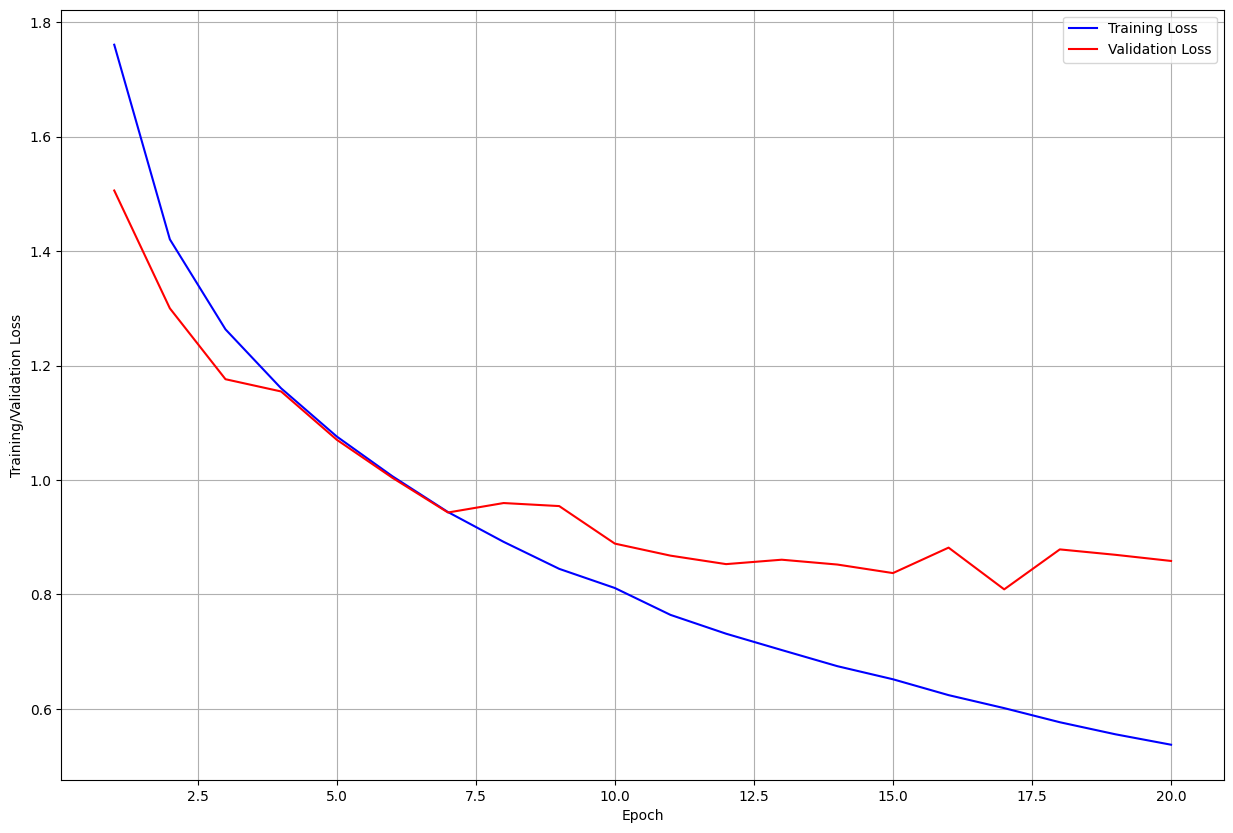

In [7]:
# Task 1 Convergence Graph

x_vals = list(range(1, len(training_loss_values)+1))
plt.figure(figsize=(15,10))
plt.plot(x_vals, training_loss_values, color='b', label='Training Loss')
plt.plot(x_vals, validation_loss_values, color='r', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Training/Validation Loss')
plt.grid(True)
plt.legend()
plt.show()

# Task 2

In [8]:
# Task 2 New Hyperparameters

L2_penalty = 0.001
dropout = 0.4

In [9]:
# Task 2 Models

class CNNBasic(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pool = nn.MaxPool2d(stride=2, kernel_size=2)
        
        # Convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(func.relu(self.conv1(x)))
        x = self.pool(func.relu(self.conv2(x)))
        x = self.pool(func.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = func.relu(self.fc1(x))
        x = func.relu(self.fc2(x))
        x = self.fc3(x)

        return x

class CNNDropout(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pool = nn.MaxPool2d(stride=2, kernel_size=2)
        self.dropout = nn.Dropout(p=dropout)
        
        # Convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(func.relu(self.conv1(x)))
        x = self.pool(func.relu(self.conv2(x)))
        x = self.pool(func.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(func.relu(self.fc1(x)))
        x = self.dropout(func.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

model_t2_basic = CNNBasic()
model_t2_basic.to(device)
crit_t2 = nn.CrossEntropyLoss()
opt_t2 = optim.Adam(model_t2_basic.parameters(), lr=learning_rate)

model_t2_reg = CNNBasic()
model_t2_reg.to(device)
opt_t2_reg = optim.Adam(model_t2_reg.parameters(), lr=learning_rate, weight_decay=L2_penalty)

model_t2_dropout = CNNDropout()
model_t2_dropout.to(device)
opt_t2_dropout = optim.Adam(model_t2_dropout.parameters(), lr=learning_rate)

In [10]:
# Task 2 Model Training and Validation - No Regularisation or Dropout

training_loss_values_basic = []
validation_loss_values_basic = []

for epoch in range(epoch_num):
    model_t2_basic.train()
    running_loss = 0.0
    for i, data in enumerate(training_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        opt_t2.zero_grad()
        outputs = model_t2_basic(inputs)
        loss = crit_t2(outputs, labels)
        loss.backward()
        opt_t2.step()
        running_loss += loss.item()
    training_loss = running_loss / len(training_loader)
    training_loss_values_basic.append(training_loss)
            
    model_t2_basic.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for validation_inputs, validation_labels in validation_loader:
            validation_inputs, validation_labels = validation_inputs.to(device), validation_labels.to(device)
            validation_outputs = model_t2_basic(validation_inputs)
            validation_loss += crit_t2(validation_outputs, validation_labels).item()
    validation_loss /= len(validation_loader)
    validation_loss_values_basic.append(validation_loss)        
        
    print(f"Epoch {epoch+1}: Training Loss = {training_loss:.3f}, Validation Loss = {validation_loss:.3f}")

print("done")

Epoch 1: Training Loss = 1.727, Validation Loss = 1.464
Epoch 2: Training Loss = 1.372, Validation Loss = 1.286
Epoch 3: Training Loss = 1.227, Validation Loss = 1.164
Epoch 4: Training Loss = 1.112, Validation Loss = 1.091
Epoch 5: Training Loss = 1.027, Validation Loss = 0.999
Epoch 6: Training Loss = 0.963, Validation Loss = 0.981
Epoch 7: Training Loss = 0.903, Validation Loss = 0.935
Epoch 8: Training Loss = 0.853, Validation Loss = 0.945
Epoch 9: Training Loss = 0.812, Validation Loss = 0.927
Epoch 10: Training Loss = 0.765, Validation Loss = 0.875
Epoch 11: Training Loss = 0.725, Validation Loss = 0.878
Epoch 12: Training Loss = 0.694, Validation Loss = 0.911
Epoch 13: Training Loss = 0.666, Validation Loss = 0.857
Epoch 14: Training Loss = 0.634, Validation Loss = 0.884
Epoch 15: Training Loss = 0.611, Validation Loss = 0.846
Epoch 16: Training Loss = 0.574, Validation Loss = 0.869
Epoch 17: Training Loss = 0.557, Validation Loss = 0.854
Epoch 18: Training Loss = 0.529, Validat

In [11]:
# Task 2 Model Training and Validation - L2 Regularisation

training_loss_values_reg = []
validation_loss_values_reg = []

for epoch in range(epoch_num):
    model_t2_reg.train()
    running_loss = 0.0
    for i, data in enumerate(training_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        opt_t2_reg.zero_grad()
        outputs = model_t2_reg(inputs)
        loss = crit_t2(outputs, labels)
        loss.backward()
        opt_t2_reg.step()
        running_loss += loss.item()
    training_loss = running_loss / len(training_loader)
    training_loss_values_reg.append(training_loss)
            
    model_t2_reg.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for validation_inputs, validation_labels in validation_loader:
            validation_inputs, validation_labels = validation_inputs.to(device), validation_labels.to(device)
            validation_outputs = model_t2_reg(validation_inputs)
            validation_loss += crit_t2(validation_outputs, validation_labels).item()
    validation_loss /= len(validation_loader)
    validation_loss_values_reg.append(validation_loss)        
        
    print(f"Epoch {epoch+1}: Training Loss = {training_loss:.3f}, Validation Loss = {validation_loss:.3f}")

print("done")

Epoch 1: Training Loss = 1.785, Validation Loss = 1.564
Epoch 2: Training Loss = 1.462, Validation Loss = 1.375
Epoch 3: Training Loss = 1.303, Validation Loss = 1.214
Epoch 4: Training Loss = 1.195, Validation Loss = 1.175
Epoch 5: Training Loss = 1.112, Validation Loss = 1.085
Epoch 6: Training Loss = 1.037, Validation Loss = 1.011
Epoch 7: Training Loss = 0.986, Validation Loss = 1.016
Epoch 8: Training Loss = 0.925, Validation Loss = 0.981
Epoch 9: Training Loss = 0.882, Validation Loss = 1.003
Epoch 10: Training Loss = 0.852, Validation Loss = 0.929
Epoch 11: Training Loss = 0.811, Validation Loss = 0.907
Epoch 12: Training Loss = 0.774, Validation Loss = 0.892
Epoch 13: Training Loss = 0.750, Validation Loss = 0.903
Epoch 14: Training Loss = 0.719, Validation Loss = 0.846
Epoch 15: Training Loss = 0.702, Validation Loss = 0.850
Epoch 16: Training Loss = 0.677, Validation Loss = 0.880
Epoch 17: Training Loss = 0.663, Validation Loss = 0.870
Epoch 18: Training Loss = 0.637, Validat

In [12]:
# Task 2 Model Training and Validation - Dropout

training_loss_values_dropout = []
validation_loss_values_dropout = []

for epoch in range(epoch_num):
    model_t2_dropout.train()
    running_loss = 0.0
    for i, data in enumerate(training_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        opt_t2_dropout.zero_grad()
        outputs = model_t2_dropout(inputs)
        loss = crit_t2(outputs, labels)
        loss.backward()
        opt_t2_dropout.step()
        running_loss += loss.item()
    training_loss = running_loss / len(training_loader)
    training_loss_values_dropout.append(training_loss)
            
    model_t2_dropout.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for validation_inputs, validation_labels in validation_loader:
            validation_inputs, validation_labels = validation_inputs.to(device), validation_labels.to(device)
            validation_outputs = model_t2_dropout(validation_inputs)
            validation_loss += crit_t2(validation_outputs, validation_labels).item()
    validation_loss /= len(validation_loader)
    validation_loss_values_dropout.append(validation_loss)        
        
    print(f"Epoch {epoch+1}: Training Loss = {training_loss:.3f}, Validation Loss = {validation_loss:.3f}")

print("done")

Epoch 1: Training Loss = 1.857, Validation Loss = 1.541
Epoch 2: Training Loss = 1.505, Validation Loss = 1.304
Epoch 3: Training Loss = 1.348, Validation Loss = 1.237
Epoch 4: Training Loss = 1.258, Validation Loss = 1.130
Epoch 5: Training Loss = 1.178, Validation Loss = 1.076
Epoch 6: Training Loss = 1.112, Validation Loss = 1.024
Epoch 7: Training Loss = 1.064, Validation Loss = 0.989
Epoch 8: Training Loss = 1.009, Validation Loss = 0.945
Epoch 9: Training Loss = 0.971, Validation Loss = 0.939
Epoch 10: Training Loss = 0.928, Validation Loss = 0.900
Epoch 11: Training Loss = 0.898, Validation Loss = 0.945
Epoch 12: Training Loss = 0.871, Validation Loss = 0.876
Epoch 13: Training Loss = 0.836, Validation Loss = 0.872
Epoch 14: Training Loss = 0.822, Validation Loss = 0.851
Epoch 15: Training Loss = 0.792, Validation Loss = 0.889
Epoch 16: Training Loss = 0.776, Validation Loss = 0.849
Epoch 17: Training Loss = 0.758, Validation Loss = 0.863
Epoch 18: Training Loss = 0.737, Validat

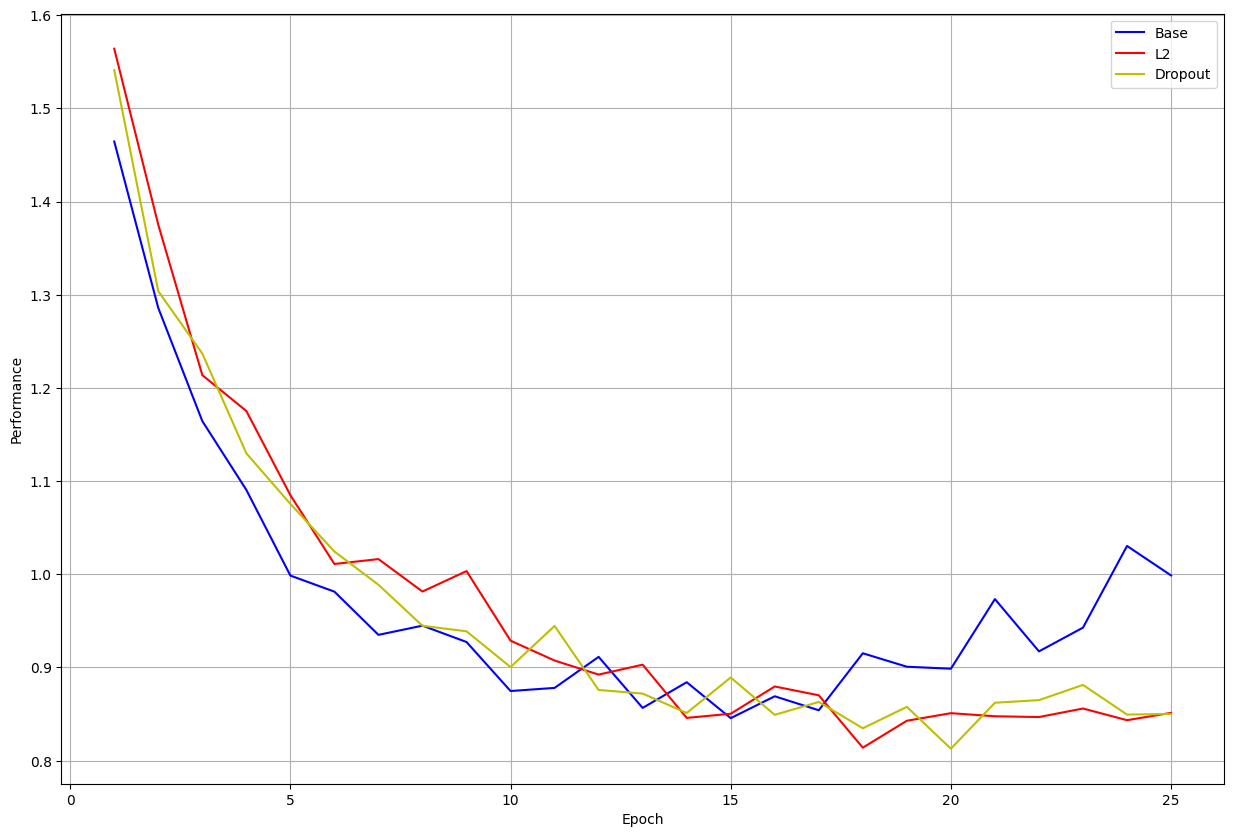

In [13]:
# Task 2 Convergence Graph

x_vals = list(range(1, epoch_num + 1))
plt.figure(figsize=(15,10))
plt.plot(x_vals, validation_loss_values_basic, color='b', label='Base')
plt.plot(x_vals, validation_loss_values_reg, color='r', label='L2')
plt.plot(x_vals, validation_loss_values_dropout, color='y', label='Dropout')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.grid(True)
plt.legend()
plt.show()

# Task 3

In [14]:
# Task 3 New Hyperparameters

num_features = [32, 32, 64]

In [15]:
# Task 3 Model

class CNNBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pool = nn.MaxPool2d(stride=2, kernel_size=2)

        # Convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.batch_norm_1 = nn.BatchNorm2d(num_features=num_features[0])
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.batch_norm_2 = nn.BatchNorm2d(num_features=num_features[1])
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.batch_norm_3 = nn.BatchNorm2d(num_features=num_features[2])
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(func.relu(self.batch_norm_1(self.conv1(x))))
        x = self.pool(func.relu(self.batch_norm_2(self.conv2(x))))
        x = self.pool(func.relu(self.batch_norm_3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = func.relu(self.fc1(x))
        x = func.relu(self.fc2(x))
        x = self.fc3(x)

        return x
    
model_t3 = CNNBatchNorm()
model_t3.to(device)
crit_t3 = nn.CrossEntropyLoss()
opt_t3 = optim.Adam(model_t3.parameters(), lr=learning_rate)

In [16]:
# Task 3 Model Training and Validation

training_loss_values_bn = []
validation_loss_values_bn = []

for epoch in range(epoch_num):
    model_t3.train()
    running_loss = 0.0
    for i, data in enumerate(training_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        opt_t3.zero_grad()
        outputs = model_t3(inputs)
        loss = crit_t3(outputs, labels)
        loss.backward()
        opt_t3.step()
        running_loss += loss.item()
    training_loss = running_loss / len(training_loader)
    training_loss_values_bn.append(training_loss)
            
    model_t3.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for validation_inputs, validation_labels in validation_loader:
            validation_inputs, validation_labels = validation_inputs.to(device), validation_labels.to(device)
            validation_outputs = model_t3(validation_inputs)
            validation_loss += crit_t3(validation_outputs, validation_labels).item()
    validation_loss /= len(validation_loader)
    validation_loss_values_bn.append(validation_loss)        
        
    print(f"Epoch {epoch+1}: Training Loss = {training_loss:.3f}, Validation Loss = {validation_loss:.3f}")

print("done")

Epoch 1: Training Loss = 1.383, Validation Loss = 1.153
Epoch 2: Training Loss = 1.012, Validation Loss = 0.947
Epoch 3: Training Loss = 0.877, Validation Loss = 0.952
Epoch 4: Training Loss = 0.789, Validation Loss = 0.885
Epoch 5: Training Loss = 0.731, Validation Loss = 0.823
Epoch 6: Training Loss = 0.684, Validation Loss = 0.836
Epoch 7: Training Loss = 0.642, Validation Loss = 0.838
Epoch 8: Training Loss = 0.605, Validation Loss = 0.837
Epoch 9: Training Loss = 0.575, Validation Loss = 0.842
Epoch 10: Training Loss = 0.545, Validation Loss = 0.882
Epoch 11: Training Loss = 0.512, Validation Loss = 0.829
Epoch 12: Training Loss = 0.480, Validation Loss = 0.812
Epoch 13: Training Loss = 0.459, Validation Loss = 0.920
Epoch 14: Training Loss = 0.446, Validation Loss = 0.863
Epoch 15: Training Loss = 0.416, Validation Loss = 0.933
Epoch 16: Training Loss = 0.403, Validation Loss = 0.879
Epoch 17: Training Loss = 0.382, Validation Loss = 0.850
Epoch 18: Training Loss = 0.363, Validat

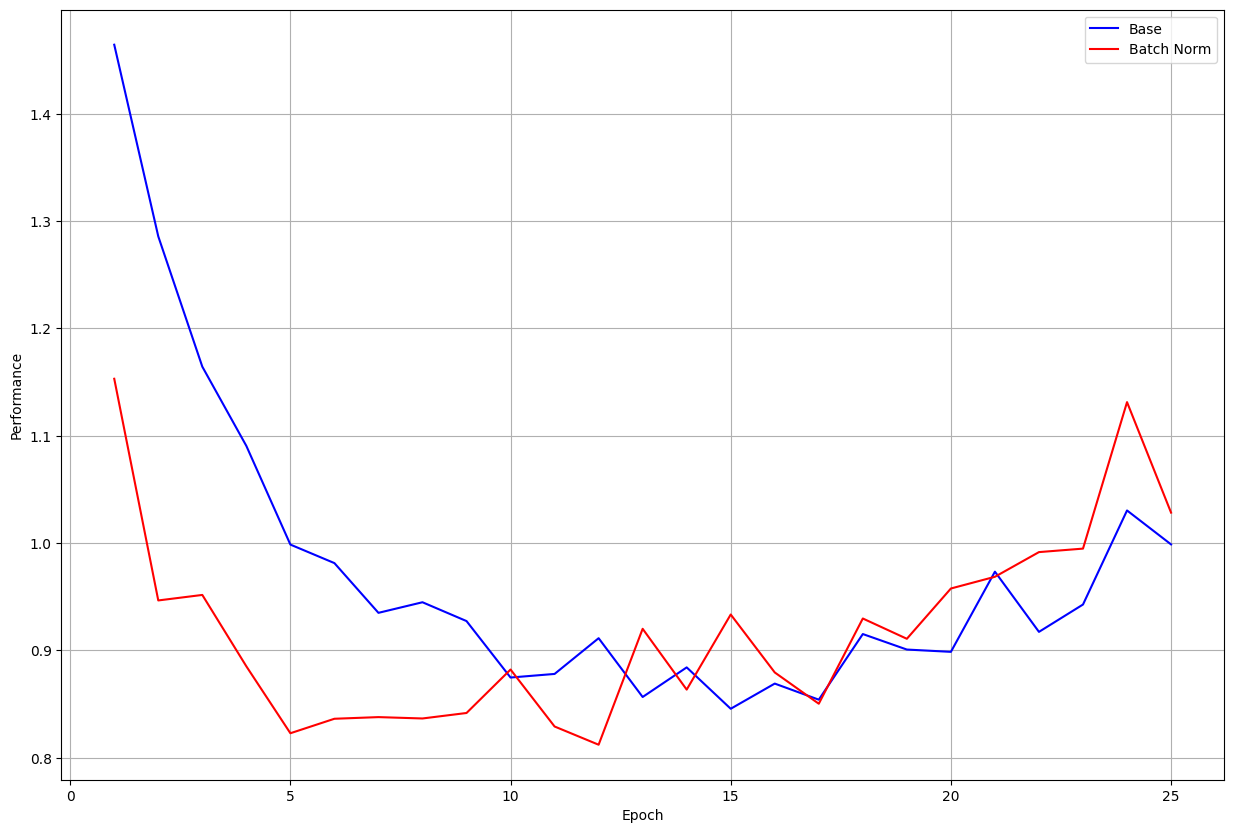

In [17]:
# Task 3 Convergence Graph

x_vals = list(range(1, epoch_num + 1))
plt.figure(figsize=(15,10))
plt.plot(x_vals, validation_loss_values_basic, color='b', label='Base')
plt.plot(x_vals, validation_loss_values_bn, color='r', label='Batch Norm')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.grid(True)
plt.legend()
plt.show()

# Task 4

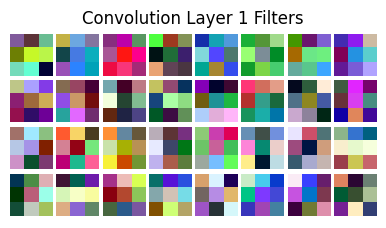

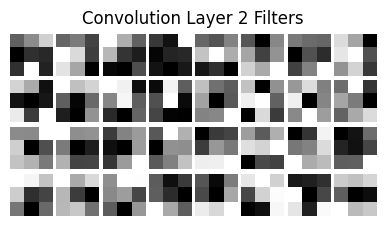

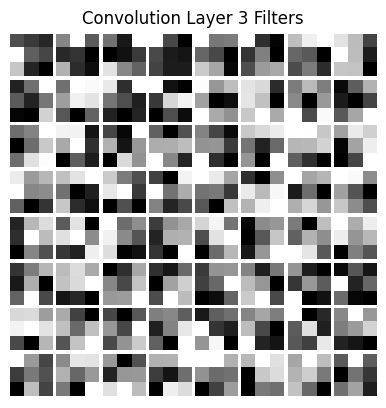

In [132]:
# Filter Visualisation

model_t4 = CNN()
model_t4.load_state_dict(torch.load("cnn_model.pth", weights_only=True))
model_t4.to(device)

conv1_filters = model_t4.conv1.weight.data.cpu()
conv1_num_filters = conv1_filters.shape[0]
plt.figure(figsize=(3.66, 3.66))
plt.title('Convolution Layer 1 Filters')
plt.axis('off')
for i in range(conv1_num_filters):
    plt.subplot(4, 8, i+1)
    filter = conv1_filters[i]
    filter = (filter - filter.min()) / (filter.max() - filter.min())
    plt.imshow(np.transpose(filter.numpy(), (1, 2, 0)))
    plt.axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0, left=0, right=1, top=0.51, bottom=0)
plt.show()

conv2_filters = model_t4.conv2.weight.data.cpu()
conv2_num_filters = conv2_filters.shape[0]
plt.figure(figsize=(3.66, 3.66))
plt.title('Convolution Layer 2 Filters')
plt.axis('off')
for i in range(conv2_num_filters):
    plt.subplot(4, 8, i+1)
    filter = conv2_filters[i]
    filter = filter.mean(dim=0)
    filter = (filter - filter.min()) / (filter.max() - filter.min())
    plt.imshow(filter.numpy(), cmap='gray')
    plt.axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0, left=0, right=1, top=0.51, bottom=0)
plt.show()

conv3_filters = model_t4.conv3.weight.data.cpu()
conv3_num_filters = conv3_filters.shape[0]
plt.figure(figsize=(3.66, 3.66))
plt.title('Convolution Layer 3 Filters')
plt.axis('off')
for i in range(conv3_num_filters):
    plt.subplot(8, 8, i+1)
    filter = conv3_filters[i]
    filter = filter.mean(dim=0)
    filter = (filter - filter.min()) / (filter.max() - filter.min())
    plt.imshow(filter.numpy(), cmap='gray')
    plt.axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0, left=0, right=1, top=1, bottom=0)
plt.show()

In [245]:
data = iter(testing_loader)
images, labels = next(data)

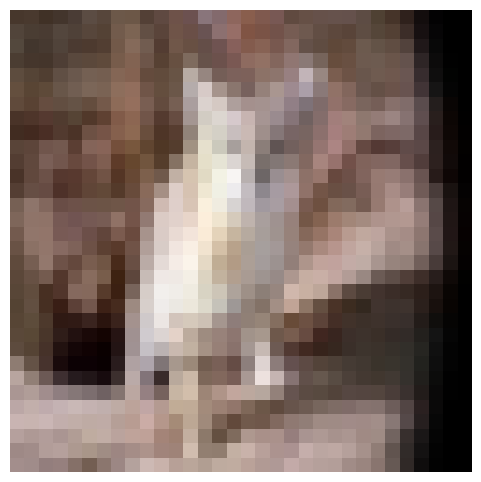

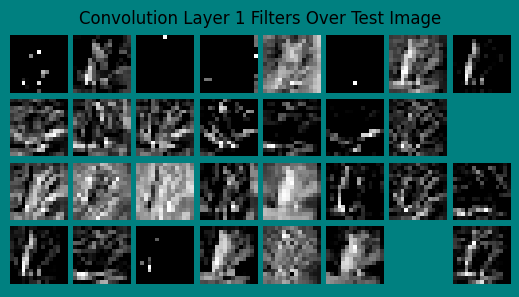

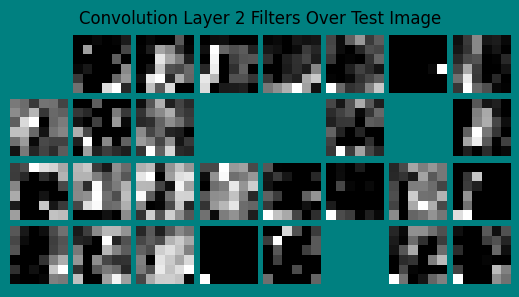

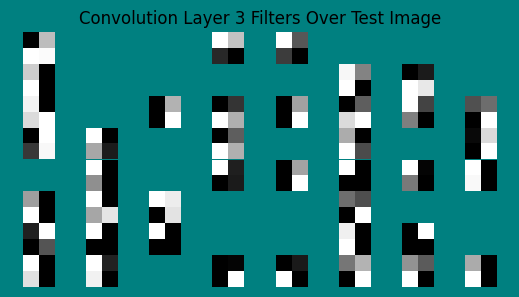

In [284]:
# Test Image Visualisation

image = images[127].unsqueeze(0).to(device)
image = (image * 0.5) + 0.5

plt.figure(figsize=(6, 6))
plt.imshow(np.transpose(image[0].cpu().numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

model_t4.eval()
with torch.no_grad():
    conv1_output = model_t4.pool(func.relu(model_t4.conv1(image)))
    conv2_output = model_t4.pool(func.relu(model_t4.conv2(conv1_output)))
    conv3_output = model_t4.pool(func.relu(model_t4.conv3(conv2_output)))
    
conv1_output = conv1_output.cpu()
conv2_output = conv2_output.cpu()
conv3_output = conv3_output.cpu()

plt.figure(figsize=(5, 5), facecolor='teal')
plt.title('Convolution Layer 1 Filters Over Test Image')
plt.axis('off')
for i in range(conv1_output.shape[1]):
    plt.subplot(4, 8, i+1)
    filter = conv1_output[0, i]
    filter = (filter - filter.min()) / (filter.max() - filter.min())
    plt.imshow(filter.numpy(), cmap='gray')
    plt.axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0, left=0, right=1, top=0.51, bottom=0)
plt.show()

plt.figure(figsize=(5, 5), facecolor='teal')
plt.title('Convolution Layer 2 Filters Over Test Image')
plt.axis('off')
for i in range(conv2_output.shape[1]):
    plt.subplot(4, 8, i+1)
    filter = conv2_output[0, i]
    filter = (filter - filter.min()) / (filter.max() - filter.min())
    plt.imshow(filter.numpy(), cmap='gray')
    plt.axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0, left=0, right=1, top=0.51, bottom=0)
plt.show()

plt.figure(figsize=(5, 5), facecolor='teal')
plt.title('Convolution Layer 3 Filters Over Test Image')
plt.axis('off')
for i in range(conv3_output.shape[1]):
    plt.subplot(8, 8, i+1)
    filter = conv3_output[0, i]
    filter = (filter - filter.min()) / (filter.max() - filter.min())
    plt.imshow(filter.numpy(), cmap='gray')
    plt.axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0, left=0, right=1, top=0.51, bottom=0)
plt.show()